# WB - Praca domowa 4

autor: Paulina Przybyłek

In [1]:
import numpy as np
import pandas as pd
import dalex as dx
import pickle
import warnings
warnings.filterwarnings('ignore')

## Wczytanie zbioru danych *heart* oraz modelu 

Wykorzystamy nasz stworzony zbiór danych, który opisany został przy drugiej pracy domowej, i modele: Random Forest, SVC, KNN oraz Naive Bayes.

In [2]:
# wczytujemy treningowy zbiór danych - na treningowym model został nauczony
data = pd.read_csv('heart_train.csv')
data.head()

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,...,thal_fd,thal_rd,slope_up,slope_flat,slope_down,cp_ta,cp_aa,cp_np,cp_a,target
0,56,1,125,249,1,1,144,1,1.2,1,...,0,0,0,1,0,1,0,0,0,1
1,44,1,112,290,0,1,153,0,0.0,1,...,0,0,1,0,0,1,0,0,0,1
2,62,0,140,394,0,1,157,0,1.2,0,...,0,0,0,1,0,1,0,0,0,0
3,35,1,120,198,0,0,130,1,1.6,0,...,0,1,0,1,0,1,0,0,0,1
4,56,0,140,294,0,1,153,0,1.3,0,...,0,0,0,1,0,0,1,0,0,0


In [3]:
target_train = data.target.values
data_train = data.drop(['target'], axis = 1)

In [4]:
rf = pickle.load(open('./Modele/random_forest', 'rb'))
nb = pickle.load(open('./Modele/naive_bayes', 'rb'))
knn = pickle.load(open('./Modele/knn', 'rb'))

In [5]:
# wczytany model SVC z pickle nie działa jakoś poprawnie, dlatego tworzymy go tutaj
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
svc = Pipeline(
    [
        ('standardscaler', StandardScaler()),
        ('SVC', SVC( C = 0.5, random_state=1, probability=True))
    ]
)
svc.fit(data_train, target_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('SVC', SVC(C=0.5, probability=True, random_state=1))])

## Permutacyjna ważność zmiennych dla wybranego modelu

Wybrano model lasu losowego, ponieważ to na nim skupiliśmy się w projekcie. Metoda permutacyjnej ważności zmiennej pozwoli zdobyć nowe informacje o danych oraz modelu przy czym celem jest potwierdzenie hipotez medycznych oraz zauważonych wniosków przy wyjaśnieniach lokalnych.

In [6]:
explainer = dx.Explainer(rf, data_train, target_train, label = "Random Forest")

Preparation of a new explainer is initiated

  -> data              : 242 rows 20 cols
  -> target variable   : 242 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Random Forest
  -> predict function  : <function yhat_proba_default at 0x7f00f61de7b8> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0322, mean = 0.46, max = 0.988
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.738, mean = -0.00088, max = 0.81
  -> model_info        : package sklearn

A new explainer has been created!


In [7]:
fi = explainer.model_parts()

In [9]:
fi.plot()

Najważniejszą zmienną dla modelu okazuje się zmienna **ca**, czyli badanie uwapnienia. Krótko przypominając, jest to zmienna, która określa liczbę naczyń zabarwionych podczas badania uwapnienia, a im większa liczba tych naczyń tym wiąże się to z utrudnionym przepływem krwi, zwężeniem naczyń głównych serca czy występowaniem blaszek miażdżycowych. Grupa na podstawie konsultacji z lekarzem i wyjaśńień lokalnych uznała tę zmienną za kluczową, natomiast teraz dowiadujemy się, że jest ona najważniejsza dla modelu lasu losowego. 

Podczas pracy nad zbiorem oraz zgłębianiu wiedzy medycznej ustalono, że najważniejsze zmienne, które dotyczą choroby wieńcowej to w teorii ca (uwapnienie), cp (bóle w klatce, a szczególnie 'typical angina'), thal (wady serca, ubytki w sercu), oldpeak (dotyczy zmian w badaniu EKG, przy czym slope jest z nim powiązany), a także z takich bardziej oczywistych jest to wiek oraz tętno. Przyglądając się ważności zmiennym to 6 pierwszych zmiennych właśnie dotyczy tych zmiennych. 

Mówiąc coś więcej o określonej ważności to ciekawe jest, że thal występuje tak nisko, jednak analizując działanie metody permutacyjnej ważności zmiennych oraz znaczenie innych zmiennych nie jest to już zaskakujące. Dlaczego? Mianowicie ca, oldpeak oraz typical angina mają określone wartości, które jasno wskazują chorego. Dodatkowo osoby starsze częściej chorują na CAD, tętno zależy od wieku i występowania choroby (ponieważ jest to próba wysiłkowa, a osoby starsze i chore kończą ją wcześniej i mają niskie tętno uzyskane podczas badania). I dopiero wtedy pojawia się zmienna oznaczająca brak wady, już nie jest ważne jaka to wada, chociaż to właśnie thal_rd określa chorobę częściej. 

Warto wspomnieć też coś o płci - dane medyczne jasno mówią, że mężczyźni częściej są dotknięci chorobą wieńcową, często to właśnie płeć i wiek określają czy lekarz wyśle chorego na konkretne badania. Stąd w zbiorze było bardzo podobnie i występuje dużo więcej chorych mężczyzn, co warto przypomnieć. Poniżej załączono rozkład płci względem chorowania na serce (1 - mężczyzna, 0 - kobieta).

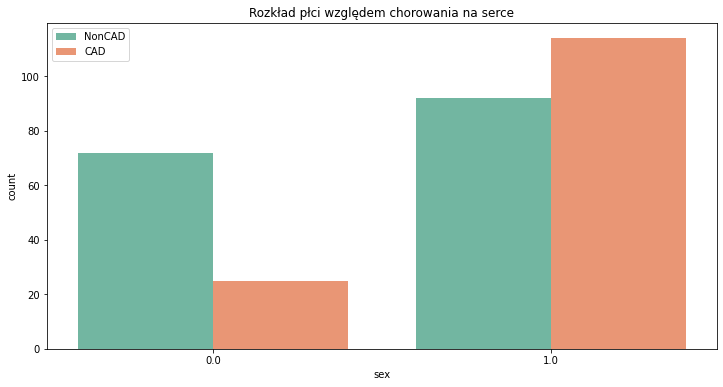

Na zakończenie to chciałam powiedzieć coś o zmiennej określającej cholesterol pacjentów. Afroamerykanie mają bardzo dziwny i zaburzony, a wykresy rozkładu nic nie powiedziały więcej stąd ciekawe jest to, że model uważa tę zmienną za dość ważną. Co prawda czasem pojawiała się w wyjaśnieniach lokalnych, ale uznano to za nietypowe przypadki, których nie da się medycznie wyjaśnić właśnie z powodu tej dziwności cholesterolu u pacjentów co lekarze uważają za normalne.

Poniżej przedstawiono jeszcze tabelę ważności wszystkich zmiennych, na której bazuje wykres, który właśnie omówiono. Przy niej powiemy trochę o najmniej ważnych zmiennych.

In [10]:
fi.result

,variable,dropout_loss,label
0,thal_fd,0.033980,Random Forest
1,_full_model_,0.034042,Random Forest
2,cp_aa,0.034124,Random Forest
3,slope_down,0.034386,Random Forest
4,fbs,0.034399,Random Forest
5,slope_flat,0.035568,Random Forest
6,cp_a,0.035775,Random Forest
7,slope_up,0.037164,Random Forest
8,cp_np,0.037178,Random Forest
9,restecg,0.037178,Random Forest


Kolejny raz mamy potwierdzenie, że cukrzyca nie ma bezpośredniego wpływu na chorobę, jej ważność jest znikoma. Chociaż do najmniej ważnych należą zmienne po one hot encodingu, które to wartości konkretne nie określają ani zdrowia ani choroby jak np. atypowa angina, slope_down i slope_flat czy naprawiona wada. Osoba chora jak i zdrowa mogą je posiadać. 

## Porównanie ważności zmiennych dla lasu losowego z wynikami tej metody zastosowanej dla innych modeli

Sprawdzimy teraz jak różnią się wybrane zmienne dla innych modeli. Inne rozważane modele to SVC na standaryzowanych danych oraz KNN na znormalizowanych danych i Naive Bayes. Tak więc mamy i glass boxy jak i black boxy do porównania ważności zmiennych.

In [11]:
data_norm = (data_train - np.min(data_train)) / (np.max(data_train) - np.min(data_train)).values
explainer_knn = dx.Explainer(knn, data_norm, target_train, label = "KNN")
explainer_nb = dx.Explainer(nb, data_train, target_train, label = "Naive Bayes")
explainer_svc = dx.Explainer(svc, data_train, target_train, label = "SVC")

Preparation of a new explainer is initiated

  -> data              : 242 rows 20 cols
  -> target variable   : 242 values
  -> model_class       : sklearn.neighbors._classification.KNeighborsClassifier (default)
  -> label             : KNN
  -> predict function  : <function yhat_proba_default at 0x7f00f61de7b8> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.453, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.941, mean = 0.00559, max = 0.882
  -> model_info        : package sklearn

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 242 rows 20 cols
  -> target variable   : 242 values
  -> model_class       : sklearn.naive_bayes.GaussianNB (default)
  -> label             : Naive Bayes
  -> predict function  : <function y

In [12]:
fi_knn = explainer_knn.model_parts()
fi_nb = explainer_nb.model_parts()
fi_svc = explainer_svc.model_parts()

Poniżej można zobaczyć wykres wszystkich 4 modeli razem.

In [13]:
fi.plot([fi_knn, fi_nb, fi_svc], max_vars = 21)

Na pierwszy rzut oka widać pozycję na osi wartości (1 - AUC(model)), przy czym wybrany las losowy do analizy jest najlepszy, następnie jest SVC, KNN oraz Naive Bayes. Jak wiadomo Naive Bayes nie bierze pod uwagę interacji i zależności zmiennych stąd nie powinna dziwić jego pozycja.

Przyglądając się zmiennej **ca**, to nie wszystkie modele wybrały ją za najważniejszą, dla modelu KNN, to właśnie **typical angina (cp_ta)** jest ważniejsza. Trudno tu toczyć spór, czy to błąd, ponieważ obie zmienne są ważne dla znalezienia chorych pacjentów. W wyjaśnieniach lokalnych dowiedzieliśmy się, że występowanie tylko jednego objawu nie musi oznaczać Choroby wieńcowej a inną chorobę serca, więc i tak chorych pacjentów przewiduje się co najmniej po kilku objawach np. po ca, cp, oldpeak i thal, które we cztery z dobrymi wartościami potrafią wskazać osobę chorą z dużą pewnością.

Co więcej możemy powiedzieć o ważności zmiennych?
* jakby spojrzeć na pierwsze 6 najważniejszych zmiennych to mimo innej kolejności powtarzają się zmienne: ca, płeć oraz cp (niekoniecznie ta sama wartość). Czyli zmienne, które jasno określają większe prawdopodobieństwo choroby. Natomiast 3/4 modele wyznaczyły za najważniejsze dodatkowo: oldpeak, exang, tętno maksymalne oraz thal. Exang dotyczy dławicy wysiłkowej, która często pojawia się z bólem typical angina (cp_ta), natomiast o ważności tętna, wad serca i oldpeak już wspomniano. Modele dobrze określiły najważniejsze zmienne
* ciekawe jest, że tylko Random Forest wytypował silne zmaczenie wieku, reszta modeli ma go pod koniec listy ważności zmiennych, możliwe, że nie wyciągają z niego zbytniej wartości, ponieważ wszystko co można określić na wieku jest skorelowane np. z tętnem, który to od wieku właśnie zależy. 
* model SVC oraz KNN uważają restecg za ważniejsze niż reszta modeli, badanie EKG może być dobrym wskaźnikiem zaburzeń pracy serca, przy czym zmienna restecg przewiduje czy są zaburzenia czy nie ma, skąd można coś wywnioskować, jednak lepszą zmienną, która również dotyczy badania EKG jest oldpeak, który już szczegółowo określa jak krzywa EKG się zachowuje, dlatego tę zmienną większość modeli ma prawie na piedestale.
* warto wspomnieć, że Naive Bayes nie wziął pod uwagę zmiennej cp_ta, czyli typical angina, za jedną z ważniejszych, pojawia się natomiast zmienna cp_np, czyli ból nie związany z anginą, przy czym on uznaje zmienne za niezależne i może właśnie dlatego typical angina nie okazała się najważniejsza - koreluje ona z wiekiem, płcią czy exang i np. dla starszych mężczyzn pojawienie się typical angina jest jednoznaczne z chorobą wieńcową.

## Podsumowanie

Przyjrzeliśmy się najważniejszym zmiennym dla modeli, porównując to z medycznym punktem widzenia, modele podobnie wybrały zmienne najważniejsze - na podium znalazły się ca, cp, oldpeak, sex, thalach, thal. Są to zmienne, po których widać objawy choroby wieńcowej. Nasz model wybrany do projektu, czyli Random Forest umieścił też wiek dość wysoko, który ma wpływ na chorobę, chociaż bardziej jego udział przejawia się w tętnie czy połączeniu wieku, płci i bólu w klatce.

Podsumowując, wciąż mamy potwierdzenie w tym co uważamy za znaczące dla choroby wieńcowej, chociaż w przypadku danych medycznych objawy są często jasno określone i jedynie możemy się cieszyć, że wyjaśnienia modelu potwierdzają teorie wysnute przez lekarzy na podstawie lat badań.